In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def printImg(img):
    %matplotlib inline
    plt.imshow(img, cmap = cm.Greys)
    plt.show()

### Chargement des données

In [2]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
data = fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = data

### 1. Regression linéaires multiples
Je prends les données, je les transforment en un array de dimension 1, ensuite je les centre et normalise.

In [3]:
from statsmodels.regression.linear_model import OLS
X = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X = X/256
X = X-0.5
m = OLS(y_train,X)
results = m.fit()
su = results.summary()

In [4]:
print(su)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                -637.946
Model:                            OLS   Adj. R-squared (uncentered):           -646.405
Method:                 Least Squares   F-statistic:                             -75.41
Date:                Sun, 02 Jan 2022   Prob (F-statistic):                        1.00
Time:                        18:19:19   Log-Likelihood:                     -1.0398e+05
No. Observations:               60000   AIC:                                  2.095e+05
Df Residuals:                   59216   BIC:                                  2.166e+05
Df Model:                         784                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

On observe bien que la valeur du R² est très éloignée de 1 . Le modèle est donc complètement inutilisable.

Une autre méthode serait peut être de ne pas travailler sur chaque pixel, mais sur la somme des lignes ou des collones. On va tenter les deux opérations:

#### 1.1: Somme des lignes

In [5]:
def lineSum(X_data):
    X_out = np.zeros((X_data.shape[0],X_data.shape[1],1))
    for i in range (X_out.shape[0]):
        img = X_data[i]
        outimg = np.array([np.sum(line) for line in img])
        outimg = np.reshape(outimg,(outimg.shape[0],1))
        outimg = outimg/(outimg.shape[0])
        X_out[i] = outimg
    return X_out

In [6]:
X_lined = lineSum(X_train)

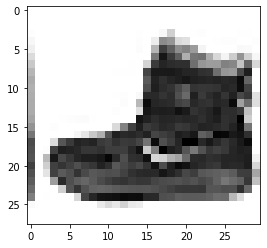

In [7]:
img_test = X_lined[0]
img_test = np.concatenate((img_test,np.zeros((28,1))),axis=1)
img_test = np.concatenate((img_test,X_train[0]),axis=1)
printImg(img_test)

In [8]:
X_l = np.reshape(X_lined,(X_lined.shape[0],X_lined.shape[1]*X_lined.shape[2]))
X_l = X_l/256
X_l = X_l-0.5
m = OLS(y_train,X_l)
results = m.fit()
su = results.summary()
print(su)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                -994.857
Model:                            OLS   Adj. R-squared (uncentered):           -995.322
Method:                 Least Squares   F-statistic:                             -2140.
Date:                Sun, 02 Jan 2022   Prob (F-statistic):                        1.00
Time:                        18:19:28   Log-Likelihood:                     -1.1730e+05
No. Observations:               60000   AIC:                                  2.346e+05
Df Residuals:                   59972   BIC:                                  2.349e+05
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

La version de la somme d'une ligne est moins efficace que la version pixel par pixel.

#### 1.1: Somme des collones

In [9]:
def columnSum(X_data):
    X_out = np.zeros((X_data.shape[0],1,X_data.shape[1]))
    for i in range (X_out.shape[0]):
        img = X_data[i].T
        outimg = np.array([np.sum(line) for line in img])
        outimg = np.reshape(outimg,(outimg.shape[0],1))
        outimg = outimg/(outimg.shape[0])
        X_out[i] = outimg.T
    return X_out

In [10]:
X_col = columnSum(X_train)

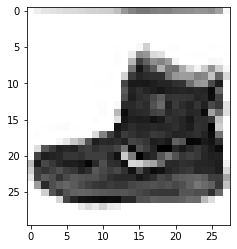

In [11]:
img_test = X_col[0]
img_test = np.concatenate((img_test,np.zeros((1,28))),axis=0)
img_test = np.concatenate((img_test,X_train[0]),axis=0)
printImg(img_test)

In [12]:
X_c = np.reshape(X_col,(X_col.shape[0],X_col.shape[1]*X_col.shape[2]))
X_c = X_c/256
X_c = X_c-0.5
m = OLS(y_train,X_c)
results = m.fit()
su = results.summary()
print(su)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):               -1252.020
Model:                            OLS   Adj. R-squared (uncentered):          -1252.605
Method:                 Least Squares   F-statistic:                             -2140.
Date:                Sun, 02 Jan 2022   Prob (F-statistic):                        1.00
Time:                        18:19:38   Log-Likelihood:                     -1.2419e+05
No. Observations:               60000   AIC:                                  2.484e+05
Df Residuals:                   59972   BIC:                                  2.487e+05
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

On observe qu'ici aussi le resulat est plus mauvais que celui du pixel par pixel.

Il me semble logique que les deux projections ont un moins bon résultat que la version pixel par pixel. En effet la perte d'information  faite lors des projections est bien trop grande. Si l'on voulait éviter ce genre de problèmes, il vaudrait mieux faire une ACP ou une ACI.

## Classificateur Bayesien

In [13]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X, y_train)

GaussianNB()

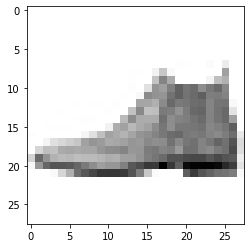

9
[7]


In [14]:
printImg(X_test[0])
print(y_test[0])
x_test0 = np.reshape(X_test[0],(X_test[0].shape[0]*X_test[0].shape[1]))
x_test0 = x_test0/256
x_test0 = x_test0 - 0.5
print(nb.predict([x_test0]))

In [15]:
from sklearn.metrics import confusion_matrix
X_testLineraiszed = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
X_testLineraiszed = X_testLineraiszed/256
X_testLineraiszed = X_testLineraiszed - 0.5
y_testPred = nb.predict(X_testLineraiszed)
conMat = confusion_matrix(y_test, y_testPred)
print(conMat)
acc = np.sum(np.diag(conMat))/np.sum(conMat)
print('{:.2%}'.format(acc))

[[586  64  29 162 110   0  20   0  29   0]
 [  1 939  14  36   7   0   1   0   2   0]
 [  7  14 324  65 545   0  23   0  22   0]
 [  9 387   6 545  43   0   4   0   6   0]
 [  0  34  44 131 779   0   4   0   8   0]
 [  0   0   1   1   0 278   3 660   5  52]
 [117  34 112 200 435   0  40   0  62   0]
 [  0   0   0   0   0   3   0 988   0   9]
 [  0   2  19  85 149   3  27   4 710   1]
 [  0   0   1   1   0  16   3 304   8 667]]
58.56%


On observe que le classificateur Bayesien a un resultat assez peu précis.

## Classificateur KNN

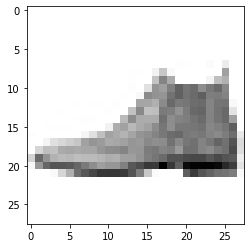

9
[9]


In [16]:
from sklearn.neighbors import KNeighborsClassifier
k = 5
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(X, y_train)
printImg(X_test[0])
print(y_test[0])

x_test0 = np.reshape(X_test[0],(X_test[0].shape[0]*X_test[0].shape[1]))
x_test0 = x_test0/256
x_test0 = x_test0 - 0.5
print(knn.predict([x_test0]))

In [17]:
y_testPred = knn.predict(X_testLineraiszed)
conMat = confusion_matrix(y_test, y_testPred)
print(conMat)
acc = np.sum(np.diag(conMat))/np.sum(conMat)
print('{:.2%}'.format(acc))

[[855   1  17  16   3   1 100   1   6   0]
 [  8 968   4  12   4   0   3   0   1   0]
 [ 24   2 819  11  75   0  69   0   0   0]
 [ 41   8  15 860  39   0  34   0   3   0]
 [  2   1 126  26 773   0  71   0   1   0]
 [  1   0   0   0   0 822   5  96   1  75]
 [176   1 132  23  80   0 575   0  13   0]
 [  0   0   0   0   0   3   0 961   0  36]
 [  2   0  10   4   7   0  16   7 953   1]
 [  0   0   0   0   0   2   1  29   0 968]]
85.54%


On observe que le knn a un resultat a   assez bon pour k = 5, je vais faire une fonction qui nous donnera le resultats pour différents k:

In [20]:
def knnTest (frm, to,metric='euclidean'):
    for k in range(frm,to):
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric,n_jobs=-1)
        knn.fit(X, y_train)
        y_testPred = knn.predict(X_testLineraiszed)
        conMat = confusion_matrix(y_test, y_testPred)
        acc = np.sum(np.diag(conMat))/np.sum(conMat)
        print('for k = ',k,' acc = {:.2%}'.format(acc))

In [21]:
knnTest(3,8)

for k =  3  acc = 85.41%
for k =  4  acc = 85.77%
for k =  5  acc = 85.54%
for k =  6  acc = 85.44%
for k =  7  acc = 85.40%


On observe que la valeur maximale est pour k = 4. En effet si on prends plus petit les valeurs sont trop faibles, et si on prend plus grand, on perd progressivement en précision car l'on prend des voisins qui se trouvent dans d'autres classes.

Essayons maintenant de changer la méthode de calcul de distance tout en gardant les memes k:

In [22]:
knnTest(3,8,'minkowski')

for k =  3  acc = 85.41%
for k =  4  acc = 85.77%
for k =  5  acc = 85.54%
for k =  6  acc = 85.44%
for k =  7  acc = 85.40%


In [23]:
knnTest(5,9,'manhattan')

for k =  5  acc = 86.23%
for k =  6  acc = 86.23%
for k =  7  acc = 86.30%
for k =  8  acc = 85.88%


#### ACP


In [24]:
from sklearn.preprocessing import StandardScaler
X = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X = X/256
X = X-0.5
scaler = StandardScaler()
z = scaler.fit_transform(X)

In [25]:
from sklearn.decomposition import PCA
pca = PCA()
print(pca)

PCA()


In [26]:
pca.fit_transform(z)

array([[-8.01174771e-01,  2.08667487e+01, -1.29451358e+01, ...,
        -1.10270152e-01, -1.40782640e-02,  5.94582173e-02],
       [ 1.70742060e+01, -4.96851249e+00, -2.07781957e+00, ...,
         1.43979158e-02, -8.79639960e-03, -6.54577116e-03],
       [-9.60164085e+00, -1.22961007e+01,  1.08228415e+00, ...,
         3.17106651e-03,  7.92388464e-03,  1.49373374e-02],
       ...,
       [ 9.37766441e+00, -1.31058579e+01, -8.83829805e+00, ...,
         2.72782448e-02, -4.49627587e-04,  5.02273514e-04],
       [-9.64563637e+00, -7.09528763e+00,  6.94533514e+00, ...,
         4.72269934e-03,  7.98533308e-03, -1.81433145e-03],
       [-2.13170793e+01, -1.74136729e+00,  5.47629241e+00, ...,
        -1.03787437e-01, -1.73135384e-02, -1.01755812e-02]])

In [27]:
print(pca.n_components_)

784


In [28]:
print(pca.explained_variance_)

[1.73137896e+02 1.13012603e+02 4.28163365e+01 3.98959607e+01
 3.17908401e+01 2.36733644e+01 2.15410670e+01 1.81393468e+01
 1.32704963e+01 1.03336329e+01 9.17376265e+00 7.54506218e+00
 7.10661624e+00 6.75040337e+00 5.82527662e+00 5.72584171e+00
 5.18669801e+00 4.95116213e+00 4.87607894e+00 4.58085356e+00
 4.10343340e+00 4.00725656e+00 3.71256369e+00 3.52868326e+00
 3.43949691e+00 3.27000669e+00 3.12303695e+00 3.06192229e+00
 2.96094002e+00 2.92849545e+00 2.84689256e+00 2.75675535e+00
 2.63460955e+00 2.59449221e+00 2.57190118e+00 2.48928424e+00
 2.39285061e+00 2.32586007e+00 2.23204333e+00 2.21928761e+00
 2.16063196e+00 2.10221955e+00 2.05704119e+00 1.99554846e+00
 1.94060149e+00 1.88353239e+00 1.86575542e+00 1.79051386e+00
 1.74106688e+00 1.69390146e+00 1.65003154e+00 1.62447385e+00
 1.59068789e+00 1.57278982e+00 1.55916668e+00 1.52201618e+00
 1.47811201e+00 1.44984072e+00 1.41420988e+00 1.38678293e+00
 1.37072550e+00 1.34334980e+00 1.32729260e+00 1.28286002e+00
 1.26238820e+00 1.251657

In [29]:
print(pca.explained_variance_ratio_.sum())

0.9999999999999998


On récupère les valeurs propres

In [30]:
eigval = pca.explained_variance_
p = X.shape[1]

On dessine l'eboulie des valeurs propres : 

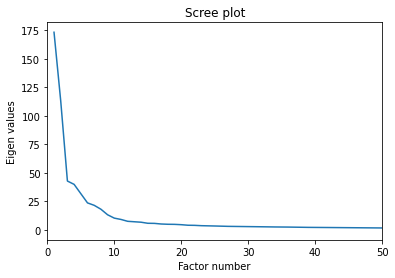

In [31]:
import numpy as np
%matplotlib inline
#scree plot
plt.plot(np.arange(1,p+1),eigval) 
plt.title("Scree plot") 
plt.ylabel("Eigen values") 
plt.xlabel("Factor number") 
plt.xlim([0, 50])
plt.show()

In [32]:
n_components = 7
pca = PCA(n_components=n_components)
pca_wine = pca.fit_transform(z)
total_variance = pca.explained_variance_ratio_.sum()
print('Total Explained Variance: ', total_variance)
print(pca_wine.shape)

Total Explained Variance:  0.5686997924981072
(60000, 7)


Avec 7 axes, ce qui permet de garder 57% de variance totale.

### 2.ACI

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [36]:
lda = LinearDiscriminantAnalysis(n_components=7)
lda = lda.fit(X, y_train)
X_train_r = lda.transform(X)
X_test_r = lda.transform(X_testLineraiszed)


On applique les algorithmes précédement testé sur les donnés après avoir fait ACI

#### 2.1 Bayesien

In [38]:
nb = GaussianNB()
nb.fit(X_train_r, y_train)
y_testPred = nb.predict(X_test_r)
conMat = confusion_matrix(y_test, y_testPred)
print(conMat)
acc = np.sum(np.diag(conMat))/np.sum(conMat)
print('{:.2%}'.format(acc))

[[772   1   6  69   4   9 121   0  18   0]
 [  2 944   2  37   2   0  11   0   2   0]
 [ 19   0 536  11 261   2 158   0  13   0]
 [ 28   5   8 837  20   6  90   0   6   0]
 [  0   5 176  43 676   2  91   0   7   0]
 [  0   0   0   0   0 899   0  54  14  33]
 [185   1 308  47 153   7 262   0  37   0]
 [  0   0   0   0   0  74   0 869   1  56]
 [  3   0   1   9   2  15  20   4 946   0]
 [  0   0   0   0   0  42   0  44   2 912]]
76.53%


#### 2.2 regressions linéaires multiples

In [39]:
m = OLS(y_train,X_train_r)
results = m.fit()
su = results.summary()
print(su)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):               -7648.376
Model:                            OLS   Adj. R-squared (uncentered):          -7649.268
Method:                 Least Squares   F-statistic:                             -8569.
Date:                Sun, 02 Jan 2022   Prob (F-statistic):                        1.00
Time:                        18:59:58   Log-Likelihood:                     -1.7846e+05
No. Observations:               60000   AIC:                                  3.569e+05
Df Residuals:                   59993   BIC:                                  3.570e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### 2.3 KNN

In [40]:
knn = KNeighborsClassifier(n_neighbors=7, metric='manhattan')
knn.fit(X_train_r, y_train)
y_testPred = knn.predict(X_test_r)
conMat = confusion_matrix(y_test, y_testPred)
acc = np.sum(np.diag(conMat))/np.sum(conMat)
print('for k = ',7,' acc = {:.2%}'.format(acc))

for k =  7  acc = 79.02%


### Forêts

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf = RandomForestClassifier()
rf.fit(X, y_train)
y_pred = rf.predict(X_testLineraiszed)
scores = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: ','{:2.2%}'.format(scores))

Accuracy:  87.60%


#### Forếts avec les données de l'ACI

In [42]:
rf = RandomForestClassifier()
rf.fit(X_train_r, y_train)
y_pred = rf.predict(X_test_r)
scores = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: ','{:2.2%}'.format(scores))

Accuracy:  80.06%
